Team members:

Anubhav Garikapadu [Net ID: ag2112]

Hittishi Kurlagunda [Net ID: hk919]

Sowmiyanarayan Selvam [Net ID: ss4370]

First, let's import `mujoco` and some other useful libraries.

In [1]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
from callbacks import *
from scipy.spatial.transform import Rotation as R

We will now set our model path, and ask MuJoCo to setup the following:

* MuJoCo's `mjModel` contains the _model description_, i.e., all quantities that *do not change over time*. 
* `mjData` contains the state and the quantities that depend on it. In order to make an `mjData`, we need an `mjModel`. `mjData` also contains useful functions of the state, for e.g., the Cartesian positions of objects in the world frame.
* `mjvCamera` and `mjvOption` are for visualization. We don't have to worry about this for now.

In [2]:
xml_path = 'rover4We-field.xml' #xml file (assumes this is in the same folder as this file)
simend = 60

# MuJoCo data structures
model = mj.MjModel.from_xml_path(xml_path)  # MuJoCo model
data  = mj.MjData(model)                    # MuJoCo data
cam   = mj.MjvCamera()                        # Abstract camera
opt   = mj.MjvOption()                        # visualization options

Next, we set up the visualization code. You don't have to change any of this code for Assignment 0.

In [3]:
# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(800, 600, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

cb = Callbacks(model,data,cam,scene)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, cb.keyboard)
glfw.set_cursor_pos_callback(window, cb.mouse_move)
glfw.set_mouse_button_callback(window, cb.mouse_button)
glfw.set_scroll_callback(window, cb.scroll)

# Example on how to set camera configuration
cam.azimuth = 90 ; cam.elevation = -45 ; cam.distance =  13
cam.lookat =np.array([ 0.0 , 0.0 , 0.0 ])

Now let's do something with our differential drive car. Our car has two actuators that control the velocity of the wheels. We can directly command these actuators to achieve a particular velocity by accessing `data.ctrl` variable. For a simple controller, like the one we'll be using in this notebook, this is fine. But for a more complicated controller, this will make our main simulation loop very clunky.

Thankfully, MuJoCo lets us use a control _callback_ using the `set_mjcb_control` method. A callback function is a function passed into another function as an argument, which is then invoked inside the outer function to complete some kind of routine or action.

This way, we can define our controller outside the main simulation loop, and then MuJoCo will call it automatically!

In [4]:
class Controller:
    def __init__(self,model,data):
        # Initialize the controller here.
        pass
    
    def controller(self,model,data):
        data.ctrl[0] = 0.29
        data.ctrl[1] = 0.5
        
c = Controller(model,data)
mj.set_mjcb_control(c.controller)

The below while loop will continue executing for `simend` seconds, where `simend` is the end time we defined above. MuJoCo lets us keep track of the total elapsed time using the `data.time` variable.

At a frequency of ~60Hz, it will step forward the simulation using the `mj_step` function. A more detailed explanation of what happens when you call `mj_step` is given [here](https://mujoco.readthedocs.io/en/latest/computation.html?highlight=mj_step#forward-dynamics). But for the sake of simplicity, you can asume that it applies the controls to the actuator, calculates the resulting forces, and computes the result of the dynamics.  

In [5]:
trajectory = []

while not glfw.window_should_close(window):
    time_prev = data.time

    while (data.time - time_prev < 1.0/60.0):
        mj.mj_step(model,data)
        trajectory.append([np.copy(data.site_xpos[0])])
    
    if data.time >= simend:
        break

    # ==================================================================================
    # The below code updates the visualization -- do not modify it!
    # ==================================================================================
    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam, mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()
    

glfw.terminate()

In the above code, we also maintained a trajectory of our `site`'s position by using the `data.site_xpos` variable. `data.site_xpos[0]` corresponds to the Cartesian coordinates of the first (or the 0-th) site defined in our XML model.

By stacking all the site coordinates since we started our simulation, we get a 3-dimensional array where:
* Dimension 1 corresponds to the number of data points
* Dimension 2 corresponds to the number of sites (if we had defined queried multiple sites, this would have been >1)
* Dimension 3 corresponds to the Cartesian coordinates (x,y,z)

**Exercise**: Why is the value of Dimension 1 what it is?

In [6]:
trajectory = np.array(trajectory)
print(trajectory.shape)

(657, 1, 3)


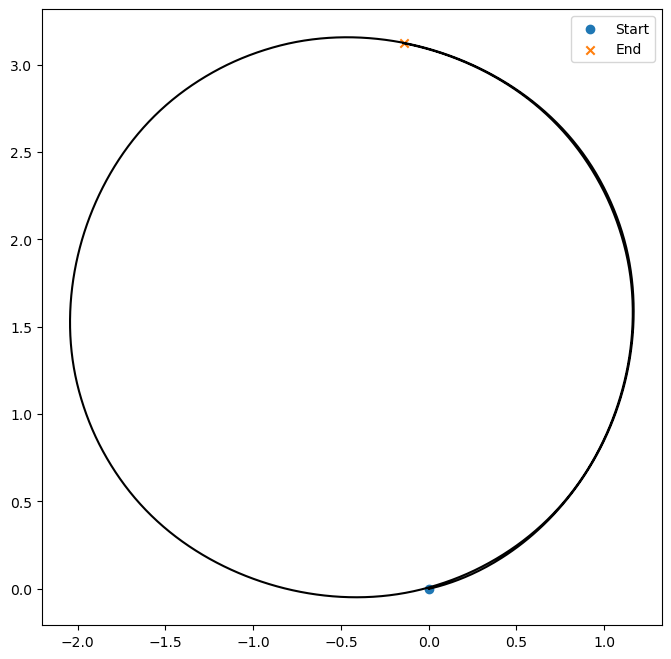

In [7]:
import matplotlib.pyplot as plt
# You need the below line only if you're using this inside a Jupyter notebook.
%matplotlib inline

plt.figure(figsize=(8,8))
plt.plot(trajectory[:,0,0],trajectory[:,0,1],color='black')
plt.scatter(trajectory[0,0,0],trajectory[0,0,1],marker='o',label='Start')
plt.scatter(trajectory[-1,0,0],trajectory[-1,0,1],marker='x',label='End')
plt.legend(loc='best')
plt.show()